In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import os


In [3]:
# Leer el archivo CSV
df = pd.read_csv('Data_Sets\Processed.csv') # Ocupamos el mismo dataset 
                                            # que ocupamos para nuestra implementación manual
# Shuffle the DataFrame rows
df = df.sample(frac=1).reset_index(drop=True)

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
df.dropna(inplace=True)

# Normalizar los datos
scaler = StandardScaler()
X = df.drop('Class', axis=1)
X = scaler.fit_transform(X)
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_Val = X_train[:int(len(X_train)*0.99)]
Y_Val = y_train[:int(len(y_train)*0.99)]

plt.style.use('bmh')

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\PC\AppData\Local\Temp\ipykernel_33700\2532592488.py:2: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv('Data_Sets\Processed.csv') # Ocupamos el mismo dataset


In [4]:
# Limpiar Terminal
os.system('cls')
# Convertir los datos a tensores de PyTorch
if torch.cuda.is_available():
    print('CUDA is available!  Training on GPU ...')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Convertir los datos a tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
X_Val = torch.tensor(X_Val, dtype=torch.float32).to(device)


y_train = y_train.values
y_test = y_test.values
Y_Val = Y_Val.values
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)
Y_Val = torch.tensor(Y_Val, dtype=torch.long).to(device)


CUDA is available!  Training on GPU ...


In [5]:
input_size = X_train.shape[1]
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)  # ajustar dinámicamente el tamaño de entrada
        self.fc2 = nn.Linear(50, 2)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# Inicializar el modelo, el optimizador y la función de pérdida
model = SimpleNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Entrenamiento de la red neuronal
num_epochs = 35000
train_losses = []
val_accs = []
test_accs = []

In [8]:
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Guardar la pérdida para graficarla
    train_losses.append(loss.item())
    
    model.eval() 
    # Move tensors to CPU before converting to NumPy arrays
    val_accs.append(accuracy_score(Y_Val.cpu().numpy(), model(X_Val).argmax(dim=1).cpu().numpy()))
    test_accs.append(accuracy_score(y_test.cpu().numpy(), model(X_test).argmax(dim=1).cpu().numpy()))

    
    # Mostrar el progreso
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {val_accs[-1]:.4f}')
    if len(train_losses) > 1 and abs(train_losses[-1] - train_losses[-2]) < 1e-6:
        break

Epoch [100/35000], Loss: 0.5809, Validation Accuracy: 0.7445
Epoch [200/35000], Loss: 0.5770, Validation Accuracy: 0.7470
Epoch [300/35000], Loss: 0.5731, Validation Accuracy: 0.7495
Epoch [400/35000], Loss: 0.5693, Validation Accuracy: 0.7517
Epoch [500/35000], Loss: 0.5654, Validation Accuracy: 0.7539
Epoch [600/35000], Loss: 0.5616, Validation Accuracy: 0.7562
Epoch [700/35000], Loss: 0.5578, Validation Accuracy: 0.7584
Epoch [800/35000], Loss: 0.5541, Validation Accuracy: 0.7607
Epoch [900/35000], Loss: 0.5503, Validation Accuracy: 0.7627
Epoch [1000/35000], Loss: 0.5466, Validation Accuracy: 0.7648
Epoch [1100/35000], Loss: 0.5429, Validation Accuracy: 0.7668
Epoch [1200/35000], Loss: 0.5393, Validation Accuracy: 0.7687
Epoch [1300/35000], Loss: 0.5357, Validation Accuracy: 0.7707
Epoch [1400/35000], Loss: 0.5321, Validation Accuracy: 0.7727
Epoch [1500/35000], Loss: 0.5285, Validation Accuracy: 0.7751
Epoch [1600/35000], Loss: 0.5249, Validation Accuracy: 0.7773
Epoch [1700/35000

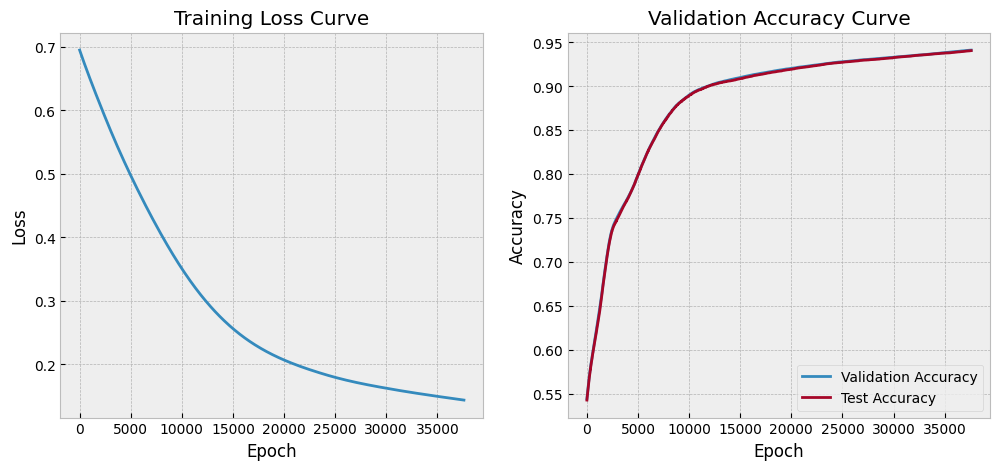

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# Graficar la curva de pérdida
plt.plot(train_losses)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
# Graficar la precisión en el conjunto de validación
plt.plot(val_accs, label='Validation Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Validation Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [17]:
# Función para anotar la matriz de confusión
def plot_confusion_matrix(cm, title, ax):
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(np.arange(cm.shape[1]))
    ax.set_yticklabels(np.arange(cm.shape[0]))
    
    # Anotar cada celda con el valor correspondiente
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')
    plt.colorbar(ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues), ax=ax)


In [18]:
# Durante la evaluación:
model.eval()
with torch.no_grad():
    valOutputs = model(X_Val).cpu()
    testOutputs = model(X_test).cpu()
    nn_pred_Val = valOutputs.argmax(dim=1).numpy()
    nn_pred_test = testOutputs.argmax(dim=1).numpy()


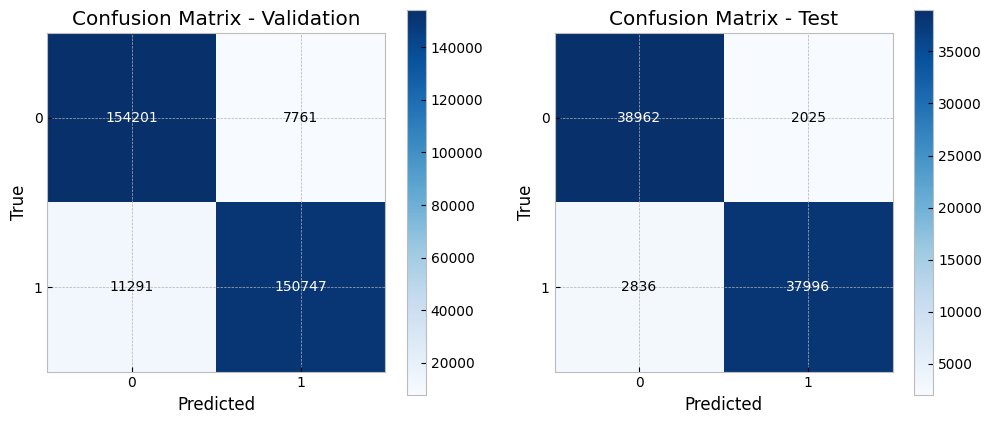

In [19]:
# Matriz de Confusión
plt.figure(figsize=(12, 5))
ax1=plt.subplot(1, 2, 1)
nn_cm = confusion_matrix(Y_Val.cpu().numpy(), nn_pred_Val)
plot_confusion_matrix(nn_cm, 'Confusion Matrix - Validation', ax1)

ax2 = plt.subplot(1, 2, 2)
nn_cm_test = confusion_matrix(y_test.cpu().numpy(), nn_pred_test)
plot_confusion_matrix(nn_cm_test, 'Confusion Matrix - Test', ax2)

plt.show()


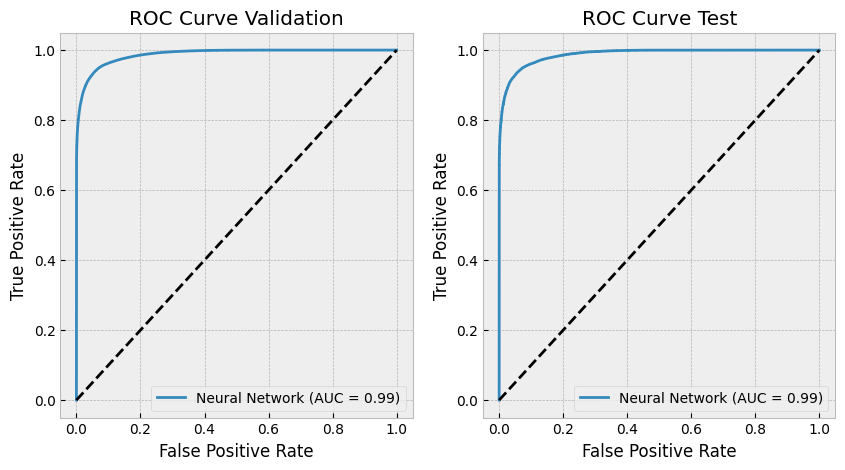

0

In [20]:
# ROC Curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
nn_fpr, nn_tpr, _ = roc_curve(Y_Val.cpu().numpy(), valOutputs[:, 1].cpu().numpy())
nn_auc = auc(nn_fpr, nn_tpr)
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Validation')
plt.legend()
plt.subplot(1, 2, 2)
nn_fpr, nn_tpr, _ = roc_curve(y_test.cpu().numpy(), testOutputs[:, 1].cpu().numpy())
nn_auc = auc(nn_fpr, nn_tpr)
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Test')
plt.legend()
plt.show()
os.system('cls')


In [21]:
print('Neural Network Evaluation')
print('-----------------------')
print(f'Validation Accuracy: {accuracy_score(Y_Val.cpu(), nn_pred_Val):.2f}')
print(f'Test Accuracy: {accuracy_score(y_test.cpu(), nn_pred_test):.2f}')
print(f'False Positive Rate: {nn_fpr[1]:.2f}')
print(f'True Positive Rate: {nn_tpr[1]:.2f}')
print(f'Validation AUC: {nn_auc:.2f}')
print(f'Test AUC: {nn_auc:.2f}')
print('-----------------------')


Neural Network Evaluation
-----------------------
Validation Accuracy: 0.94
Test Accuracy: 0.94
False Positive Rate: 0.00
True Positive Rate: 0.00
Validation AUC: 0.99
Test AUC: 0.99
-----------------------
